In [2]:
# requires magpylib==2.3.0b0

import numpy as np
import matplotlib.pyplot as plt
from magpylib.source.magnet import Cylinder
import magpylib as magpy

In [3]:
import matplotlib.patches as patches
from matplotlib.colors import LogNorm
from matplotlib import ticker
from matplotlib.ticker import FuncFormatter
from matplotlib.pyplot import cm

In [4]:
from scipy import interpolate

In [5]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [6]:
class Generator:
    
    """
    Implements the linear generator model with an array of magnets and coil windings.
    
    """
    
    def __init__(self, runID, 
                       magnetID_in, magnetOD_in, magnetH_in, magnetPosZ, magnetFlipFlag,
                       Xmin_in, Xmax_in, num_points_X,
                       Zmin_in, Zmax_in, num_points_Z, 
                       windingID_in, windingOD_in, windingH_in, windingPosZ,
                       nSegmentsX, nSegmentsZ,
                       stroke_in, freq,
                       windingFactor=0.6,
                       wire_dia_in=0.0256,
                       Brmax=1320, t_seconds=0.25, num_points=301, loadArray=np.linspace(0, 250, 26, endpoint=True),
                       runStrokeSweep=False, strokeArray_in = np.linspace(0, 3, 11, endpoint=True)):
        
        """
    Parameters:
    --------------------------
    runID : str
         identifier string for the case being run
    magnetID_in : float
        magnet inner diameter, inches
    magnetOD_in : float
        magnet outer diameter, inches
    magnetH_in : float
        magnet height, inches
    magnetPosZ : numpy.array
        Z-axis position of magnets, inches (specify center Z)
    magnetFlipFlag : numpy.array
        array of 1s and -1s to flip magnet
    Xmin_in : float
        computational domain x_min, inches
    Xmax_in : float
        computational domain x_max, inches
    num_points_X : int
        number of grid points (X-direction)
    Zmin_in : float
        computational domain z_min, inches
    Zmax_in : float
        computational domain z_max, inches
    num_points_Z : int
        number of grid points (Z-direction)
    windingID_in : float
        coil winding inner diameter, inches
    windingOD_in : float
        coil winding outer diameter, inches
    windingH_in : float
        coil winding height, inches
    windingPosZ: numpy.array
        Z-axis position of coils, inches (specify bottom level Z)
    nSegmentsX: int
        number of segments per coil, along X
    nSegmentsZ: int
        number of segments per coil, along Z
    stroke_in : float
        stroke length, inches
    freq : float
        frequency, Hz
    windingFactor : float
        factor to account for packing efficiency
    wire_dia_in: float
        wire diameter, inches
    Brmax: float
        residual magnetization, milliTesla
    """
    
        self.runID = runID
        self.magnetID_in = magnetID_in
        self.magnetOD_in = magnetOD_in
        
        self.magnetH_in = magnetH_in
        
        self.magnetPosZ = magnetPosZ
        self.magnetFlipFlag = magnetFlipFlag
        
        self.Brmax = Brmax
        
        self.Xmin_in = Xmin_in
        self.Xmax_in = Xmax_in
        
        self.Zmin_in = Zmin_in
        self.Zmax_in = Zmax_in
        
        self.num_points_X = num_points_X
        self.num_points_Z = num_points_Z
        
        self.windingID_in =  windingID_in
        self.windingOD_in =  windingOD_in
        self.windingH_in  =  windingH_in 
        self.windingPosZ  =  windingPosZ
        self.nSegmentsX    =  nSegmentsX
        self.nSegmentsZ    =  nSegmentsZ
        
        self.stroke_in = stroke_in
        self.freq = freq
        self.windingFactor = windingFactor
        
        self.t_seconds = t_seconds
        self.num_points = num_points
        
        self.loadArray = loadArray
        self.runStrokeSweep = runStrokeSweep
        self.strokeArray_in = strokeArray_in
        
        self.wire_dia_in = wire_dia_in
        self.wire_cs_mm2 = self.intomm(self.wire_dia_in)*self.intomm(self.wire_dia_in) # wire cs area, mm2
        
        print("Setting up grid...")
        # grid point locations along X and Z
        self.xs = np.linspace(self.intomm(self.Xmin_in), self.intomm(self.Xmax_in), self.num_points_X)
        self.zs = np.linspace(self.intomm(self.Zmin_in), self.intomm(self.Zmax_in), self.num_points_Z)
        print("Done.")
        
    def intomm(self, inches):
        """
        Helper function to convert inches to mm
        """
        return inches*25.4
    
    def mmtoin(self, mm):
        """
        Helper function to convert mm to inches
        """
        return mm/25.4
    
    def plotSetup(self):
        
        fig = plt.figure(figsize=(8,8))
        plt.rc('font',family='Times New Roman')
        params = {'mathtext.default': 'regular' }
        plt.rcParams.update(params)

        ax = plt.gca()
        
        for i in range(0, len(self.magnetPosZ)):

            ax.add_patch(patches.Rectangle( (0.5*self.magnetID_in, 
                                             self.magnetPosZ[i] -0.5*self.magnetH_in ),   # (x,y)
                                             0.5*(self.magnetOD_in - self.magnetID_in),          # width
                                            self.magnetH_in,          # height
                                            fill=True, facecolor='white', hatch='xxx',
                                            zorder=2))
            
            ax.add_patch(patches.Rectangle( (-0.5*self.magnetOD_in, 
                                             self.magnetPosZ[i] -0.5*self.magnetH_in ),   # (x,y)
                                             0.5*(self.magnetOD_in - self.magnetID_in),          # width
                                            self.magnetH_in,          # height
                                            fill=True, facecolor='white', hatch='xxx',
                                            zorder=2))
            
            
        for i in range(0, len(self.windingPosZ)):
        

            ax.add_patch(patches.Rectangle( (0.5*self.windingID_in, self.windingPosZ[i] ),   # (x,y)
                                            0.5*(self.windingOD_in - self.windingID_in),          # width
                                            self.windingH_in,          # height
                                            fill=True, facecolor='white',  hatch='xxx', edgecolor='xkcd:orange',
                                            zorder=2))
            
            ax.add_patch(patches.Rectangle( (-0.5*self.windingOD_in, self.windingPosZ[i] ),   # (x,y)
                                            0.5*(self.windingOD_in - self.windingID_in),           # width
                                            self.windingH_in,          # height
                                            fill=True, facecolor='white',  hatch='xxx', edgecolor='xkcd:orange',
                                            zorder=2))
            
        plt.xlim([self.Xmin_in, self.Xmax_in ])
        plt.ylim([self.Zmin_in, self.Zmax_in ])

        
        plt.xlabel("X, in" ,fontsize=16)
        plt.ylabel("Z, in" ,fontsize=16)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        ax = plt.gca()
        ax.tick_params(direction='in')
        ax.yaxis.set_ticks_position('both')
        ax.xaxis.set_ticks_position('both')
        
        plt.savefig('plots/'+str(self.runID)+'-layout.png', dpi=300, bbox_inches='tight')
        plt.savefig('plots/'+str(self.runID)+'-layout.pdf', dpi=300, bbox_inches='tight')
        plt.savefig('plots/'+str(self.runID)+'-layout.eps', dpi=300, bbox_inches='tight')
        plt.show()
    
    def createCollection(self):
        
        """
        Create magpylib collection of magnet objects
        """
        
        self.sp = [] # sp: cylinder with positive magnetization
        self.sn = [] # sn: cylinder with negative magnetization
        
        for i in range(0, len(self.magnetPosZ)):
            
            self.sp.append(Cylinder(mag=[0,0, self.Brmax*self.magnetFlipFlag[i]], dim=[self.intomm(self.magnetOD_in),self.intomm(self.magnetH_in)], 
                               pos=[0,0,self.intomm(self.magnetPosZ[i])]))
            self.sn.append(Cylinder(mag=[0,0, -self.Brmax*self.magnetFlipFlag[i]], dim=[self.intomm(self.magnetID_in),self.intomm(self.magnetH_in)], 
                               pos=[0,0,self.intomm(self.magnetPosZ[i])]))
            
        
        self.c = magpy.Collection(self.sp, self.sn)
    
    def computeBField(self):
        
        """
        Compute background magnetic field in the computational domain
        """
        print("Computing B-field...")
        # create positions
        self.posis = [[x,0,z] for z in self.zs for x in self.xs]

        # calculate field and amplitude
        self.B = [self.c.getB(pos) for pos in self.posis]
        self.Bs = np.array(self.B).reshape([self.num_points_X,self.num_points_Z,3]) #reshape
        self.Bamp = np.linalg.norm(self.Bs,axis=2)
        
        self.Bx = np.zeros((self.num_points_X,self.num_points_Z))
        self.By = np.zeros((self.num_points_X,self.num_points_Z))
        self.Bz = np.zeros((self.num_points_X,self.num_points_Z))

        for i in range(0, len(self.xs)):
            for j in range(0, len(self.zs)):

                self.Bx[i,j] = self.Bs[i, j, 0]/1e3
                self.By[i,j] = self.Bs[i, j, 1]/1e3
                self.Bz[i,j] = self.Bs[i, j, 2]/1e3
        
        # BX, BY, BZ in Tesla (interpolation functions)
        # returns B-field (Tesla) component at coordinates (x, z) [mm]
        self.BX = interpolate.interp2d(self.xs, self.zs, self.Bx, kind='linear', bounds_error=True)
        self.BY = interpolate.interp2d(self.xs, self.zs, self.By, kind='linear', bounds_error=True)
        self.BZ = interpolate.interp2d(self.xs, self.zs, self.Bz, kind='linear', bounds_error=True)
        print("Done!")
        
        
    def createBfieldPlot(self):
        
        X,Z = np.meshgrid(self.xs,self.zs)
        
        print("Plotting B-field...")
        fig = plt.figure(figsize=(8,8))
        plt.rc('font',family='Times New Roman')
        params = {'mathtext.default': 'regular' }
        plt.rcParams.update(params)

        cs = plt.contourf(self.xs/25.4,self.zs/25.4,self.Bamp,cmap='jet', 
                     levels=np.logspace(np.log10(np.min(self.Bamp)), np.log10(np.max(self.Bamp)), 100),
                     norm=LogNorm(), locator=ticker.LogLocator())



        cbar = fig.colorbar(cs)
        cbar.ax.tick_params(labelsize=16)
        cbar.set_label(r'$|B|, mTesla$', labelpad=-40, y=1.07, rotation=0, fontsize=16)

        cbar.set_ticks(np.logspace(np.log10(np.min(self.Bamp)), np.log10(np.max(self.Bamp)), 11))
        cbar.set_ticklabels(np.around(np.logspace(np.log10(np.min(self.Bamp)), np.log10(np.max(self.Bamp)), 11), 0))
        cbar.ax.tick_params(axis='y', direction='in')
        
        ax = plt.gca()
        
        self.B1 = np.array(self.B)
        self.B2 = self.B1.reshape([self.num_points_X,self.num_points_Z,3])
        U,V = self.B2[:,:,0], self.B2[:,:,2]
        ax.streamplot(X/25.4, Z/25.4, U, V, color=np.log(U**2+V**2), density=2)

        for i in range(0, len(self.magnetPosZ)):

            ax.add_patch(patches.Rectangle( (0.5*self.magnetID_in, 
                                             self.magnetPosZ[i] -0.5*self.magnetH_in ),   # (x,y)
                                             0.5*(self.magnetOD_in - self.magnetID_in),          # width
                                            self.magnetH_in,          # height
                                            fill=True, facecolor='white', hatch='xxx',
                                            zorder=2))
            
            ax.add_patch(patches.Rectangle( (-0.5*self.magnetOD_in, 
                                             self.magnetPosZ[i] -0.5*self.magnetH_in ),   # (x,y)
                                             0.5*(self.magnetOD_in - self.magnetID_in),          # width
                                            self.magnetH_in,          # height
                                            fill=True, facecolor='white', hatch='xxx',
                                            zorder=2))
            
            
        for i in range(0, len(self.windingPosZ)):
        

            ax.add_patch(patches.Rectangle( (0.5*self.windingID_in, self.windingPosZ[i] ),   # (x,y)
                                            0.5*(self.windingOD_in - self.windingID_in),          # width
                                            self.windingH_in,          # height
                                            fill=True, facecolor='white',  hatch='xxx', edgecolor='xkcd:orange',
                                            zorder=2))
            
            ax.add_patch(patches.Rectangle( (-0.5*self.windingOD_in, self.windingPosZ[i] ),   # (x,y)
                                            0.5*(self.windingOD_in - self.windingID_in),           # width
                                            self.windingH_in,          # height
                                            fill=True, facecolor='white',  hatch='xxx', edgecolor='xkcd:orange',
                                            zorder=2))

        
        plt.xlabel("X, in" ,fontsize=16)
        plt.ylabel("Z, in" ,fontsize=16)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        ax = plt.gca()
        ax.tick_params(direction='in')
        ax.yaxis.set_ticks_position('both')
        ax.xaxis.set_ticks_position('both')
        
        

        plt.savefig('plots/'+str(self.runID)+'-B-field.png', dpi=300, bbox_inches='tight')
        plt.savefig('plots/'+str(self.runID)+'-B-field.pdf', dpi=300, bbox_inches='tight')
        plt.savefig('plots/'+str(self.runID)+'-B-field.eps', dpi=300, bbox_inches='tight')
        
        plt.show()
        print("Done!")
    
    def createWindingAnchorPoints(self):
        
        """
        Create winding anchor points over the winding segments
        """
        
        # array to store X, Z coordinates of winding segment anchor points for all coil windings
        self.windingPointsX = np.zeros((len(self.windingPosZ), self.nSegmentsX, self.nSegmentsZ))
        self.windingPointsZ = np.zeros((len(self.windingPosZ), self.nSegmentsX, self.nSegmentsZ))
        
        # deltaX and deltaZ for the winding
        self.deltaWindingX = self.intomm(0.5*(self.windingOD_in-self.windingID_in))/self.nSegmentsX
        self.deltaWindingZ = self.intomm(self.windingH_in)/self.nSegmentsZ
        
        # number of turns per segment = segment area / wire cs area
        self.num_of_turns_per_segment = (self.deltaWindingX*self.deltaWindingZ)/self.wire_cs_mm2
        
        # X, Z coordinates of winding segment anchor points for all coil windings
        for i in range(0, len(self.windingPosZ)):
            for j in range(0, self.nSegmentsX):
                for k  in range(0, self.nSegmentsZ):
                    
                    self.windingPointsX[i,j,k] = 0.5*self.intomm(self.windingID_in) + self.deltaWindingX*j
                    self.windingPointsZ[i,j,k] = self.intomm(self.windingPosZ[i])   + self.deltaWindingZ*k
                    
        """
        Compute coil total resistance
        """
        
        self.RES_WINDING = np.zeros(len(self.windingPosZ))
        
        for i in range(0, len(self.windingPosZ)):
            for j in range(0, self.nSegmentsX):
                for k  in range(0, self.nSegmentsZ):
                    
                    CIR = 2*np.pi*self.windingPointsX[i,j,k]*1E-3 # m, circumeference of coil
                    RES_ONE_COIL = (4.0/76)*CIR
                    RES_PER_SEGM = RES_ONE_COIL*self.num_of_turns_per_segment*self.windingFactor
                    self.RES_WINDING[i] += RES_PER_SEGM
                    
                    
        
        
    
    def velocity_z(self, t):
        
        """
        Compute the velocity (z) at a given time
        """
        return 0.5*self.intomm(self.stroke_in)*2*np.pi*self.freq*np.cos(2*np.pi*self.freq*t)*1e-3 # m/s
    
    def coil_pos_z(self, i, j, k, t):
        
        """
        Compute the position of a coil winding anchor point at a given time
        """
        return self.windingPointsZ[i,j,k] + 0.5*self.intomm(self.stroke_in)*np.sin(2*np.pi*self.freq*t)
    
    def compute_emf(self, verbose=True):
        
        if verbose==True:
            print("Computing EMF...")
        """
        Compute the induced EMF (open circuit voltage) in each of the coil windings
        """
        
        
        self.emf_one_loop = np.zeros((len(self.windingPosZ), self.nSegmentsX, self.nSegmentsZ, self.num_points))
        self.emf_per_segm = np.zeros((len(self.windingPosZ), self.nSegmentsX, self.nSegmentsZ, self.num_points))
        self.emf_winding  = np.zeros((len(self.windingPosZ), self.num_points))
        self.RMS_OCV      = np.zeros(len(self.windingPosZ))
        
        aa = np.linspace(0, self.num_points-1, self.num_points, endpoint=True)
        tt = np.asarray(aa, dtype=int)
                                                     
        ta = tt*self.t_seconds/(self.num_points-1)
                                     
        for t in tt:
            #print("t = "+str(t*t_seconds/(num_points-1)))
            for i in range(0, len(self.windingPosZ)):
                for j in range(0, self.nSegmentsX):
                    for k  in range(0, self.nSegmentsZ):
                        
                        BXX = float(self.BX(self.windingPointsX[i,j,k], self.coil_pos_z(i, j, k, ta[t]))) # T
                        CIR = 2*np.pi*self.windingPointsX[i,j,k]*1E-3 # m


                        self.emf_one_loop[i,j,k,t]  = self.velocity_z(ta[t])*BXX*CIR
                        self.emf_per_segm[i,j,k,t]  = self.emf_one_loop[i,j,k,t]*self.num_of_turns_per_segment*self.windingFactor
                        
                     
        #print("Summing")
        for t in tt:
            #print("t = "+str(t*t_seconds/(num_points-1)))
            for i in range(0, len(self.windingPosZ)):
                for j in range(0, self.nSegmentsX):
                    for k  in range(0, self.nSegmentsZ):
                        
                        self.emf_winding[i, t]+= self.emf_per_segm[i,j,k,t]
                        self.RMS_OCV[i]  = np.sqrt(np.mean((self.emf_winding[i,:])**2))
            
            self.total_OCV = np.sum(self.RMS_OCV, axis=0)
        
        if verbose==True:
            print("EMF calculated succesfully!")
    
    def compute_Series_OCV(self, verbose=True):
        
        if verbose==True:
            print("Computing series EMF...")
        
        self.OCV_series = np.zeros(self.num_points)
        
        
        for i in range(0, len(self.windingPosZ)):
            
            self.OCV_series[:] += self.emf_winding[i,:] * (-1)**(i)
        
        self.OCV_series_RMS = np.sqrt(np.mean((self.OCV_series[:]**2)))
        
        if verbose==True:
            print("Done.")
        
    def plot_series_OCV(self):
        
        fig = plt.figure(figsize=(10,8))
        plt.rc('font',family='Times New Roman')
        params = {'mathtext.default': 'regular' }
        plt.rcParams.update(params)


        plt.plot(np.linspace(0, self.t_seconds, self.num_points)*1e3, self.OCV_series, c='green', marker='o', label='OCV signal')
        plt.axhline(y=self.OCV_series_RMS, color='k', linestyle='dashed', linewidth=3.0, label='RMS')

        plt.xlabel("Time, milliseconds", fontsize=16)
        plt.ylabel("Series Open circuit voltage, V" ,fontsize=16)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        ax = plt.gca()
        ax.tick_params(direction='in')
        ax.yaxis.set_ticks_position('both')
        ax.xaxis.set_ticks_position('both')
        plt.legend(loc='upper left', fontsize=16)

        ax.xaxis.set_tick_params(direction='in', which='both')
        ax.yaxis.set_tick_params(direction='in', which='both')

        ax.xaxis.set_tick_params(width=2, length=8)
        ax.yaxis.set_tick_params(width=2, length=8)

        ax.xaxis.set_tick_params(width=1, length=6, which='minor')
        ax.yaxis.set_tick_params(width=1, length=6, which='minor')


        ax.xaxis.grid(which='major', color='k', linestyle='dotted', linewidth=0.5)
        ax.xaxis.grid(which='minor', color='k', linestyle='dotted', linewidth=0.0)

        ax.yaxis.grid(which='major', color='k', linestyle='dotted', linewidth=0.5)
        ax.yaxis.grid(which='minor', color='k', linestyle='dotted', linewidth=0.0)

        for axis in ['top', 'bottom', 'left', 'right']:
            ax.spines[axis].set_linewidth(2)


        plt.savefig('plots/'+str(self.runID)+'-series_OCV.png', dpi=300, bbox_inches='tight')
        plt.savefig('plots/'+str(self.runID)+'-series_OCV.pdf', dpi=300, bbox_inches='tight')
        plt.savefig('plots/'+str(self.runID)+'-series_OCV.eps', dpi=300, bbox_inches='tight')

        plt.show()
        
        
    
    def computePower(self, verbose=True):
        
        if verbose==True:
            print("Computing output power and efficiency...")
        
        
        self.power_arr = np.zeros(len(self.loadArray))
        self.power_los = np.zeros(len(self.loadArray))
        self.efficiency = np.zeros(len(self.loadArray))
        
        r = np.sum(self.RES_WINDING, axis=0)
       
        
        for i in range(0, len(self.loadArray)):
            self.current = self.OCV_series_RMS / (r + self.loadArray[i])
            self.power_arr[i] = self.current**2 * self.loadArray[i]
            self.power_los[i] = self.current**2 * r
            self.efficiency[i] = self.power_arr[i]*100/(self.power_los[i]+self.power_arr[i])
        
        if verbose==True:
            print("Done.")
    
    def plotPower(self):
        
        fig = plt.figure(figsize=(10,8))
        plt.rc('font',family='Times New Roman')
        params = {'mathtext.default': 'regular' }
        plt.rcParams.update(params)
        
        plt.plot(self.loadArray, self.power_arr, c='b', marker='o', markersize=10, mfc='w', linewidth=2, label='Power output')
        #plt.plot(loadArray, self.power_los, c='blue', marker='o', label='Copper loss')

        plt.xlabel("Load resistance, "+r'$\Omega$', fontsize=16)
        plt.ylabel("Power, W" ,fontsize=16, color='b')
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        ax = plt.gca()
        ax.tick_params(direction='in')
        ax.yaxis.set_ticks_position('both')
        ax.xaxis.set_ticks_position('both')
        
        

        ax.xaxis.set_tick_params(direction='in', which='both')
        ax.yaxis.set_tick_params(direction='in', which='both')

        ax.xaxis.set_tick_params(length=8, width=2)
        ax.yaxis.set_tick_params(length=8, width=2, colors='b')

        ax.xaxis.set_tick_params(width=1, length=6, which='minor')
        ax.yaxis.set_tick_params(width=1, length=6, which='minor')


        ax.xaxis.grid(which='major', color='k', linestyle='dotted', linewidth=0.5)
        ax.xaxis.grid(which='minor', color='k', linestyle='dotted', linewidth=0.0)

        ax.yaxis.grid(which='major', color='k', linestyle='dotted', linewidth=0.5)
        ax.yaxis.grid(which='minor', color='k', linestyle='dotted', linewidth=0.0)
        
        

        for axis in ['top', 'bottom', 'left', 'right']:
            ax.spines[axis].set_linewidth(3)
        
        ax2 = ax.twinx()
        ax2.plot(self.loadArray, self.efficiency, c='g', marker='^', markersize=10, mfc='w',linewidth=2,  label='Efficiency')

        ax2.xaxis.grid(which='major', color='k', linestyle='dotted', linewidth=0.5)
        ax2.xaxis.grid(which='minor', color='k', linestyle='dotted', linewidth=0.5)

        ax2.yaxis.grid(which='major', color='k', linestyle='dotted', linewidth=0.5)
        ax2.yaxis.grid(which='minor', color='k', linestyle='dotted', linewidth=0.5)

        ax2.xaxis.set_tick_params(length=8, width=2)
        ax2.yaxis.set_tick_params(length=8, width=2)

        ax2.tick_params(direction='in')
        #ax2.yaxis.set_ticks_position('both')
        ax2.xaxis.set_ticks_position('both')
        ax2.tick_params(axis='x',labelsize=16)
        ax2.tick_params(axis='y',labelsize=16, colors='g')

        #ax2.set_xlabel('Expansion Phase Angle Advance',fontsize=16)
        ax2.set_ylabel('Efficiency', fontsize=16, color='g')
        ax2.spines['right'].set_color('g')
        ax2.spines['right'].set_linewidth(3)
        ax2.legend(loc='lower right', fontsize=16)
        
        ax.spines['left'].set_color('b')
        ax.spines['left'].set_linewidth(3)
        ax.legend(loc='lower center', fontsize=16)


        plt.savefig('plots/'+str(self.runID)+'-power-out.png', dpi=300, bbox_inches='tight')
        plt.savefig('plots/'+str(self.runID)+'-power-out.pdf', dpi=300, bbox_inches='tight')
        plt.savefig('plots/'+str(self.runID)+'-power-out.eps', dpi=300, bbox_inches='tight')

        plt.show()
            
    def plotOCV(self):
        
        fig = plt.figure(figsize=(10,8))
        plt.rc('font',family='Times New Roman')
        params = {'mathtext.default': 'regular' }
        plt.rcParams.update(params)
        color = iter(cm.rainbow(np.linspace(0, 1, len(self.windingPosZ))))
        
        for i in range(0, len(self.windingPosZ)):

            c = next(color)
            plt.plot(np.linspace(0, self.t_seconds, self.num_points)*1e3, self.emf_winding[i,:], c=c, marker='o', label="Coil "+str(i+1))
            plt.axhline(y=self.RMS_OCV[i], linestyle='dashed', color=c, linewidth=2.0)
            
        plt.xlabel("Time, milliseconds", fontsize=16)
        plt.ylabel("Open circuit voltage, V" ,fontsize=16)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        ax = plt.gca()
        ax.tick_params(direction='in')
        ax.yaxis.set_ticks_position('both')
        ax.xaxis.set_ticks_position('both')
        plt.legend(loc='upper left', fontsize=16)

        ax.xaxis.set_tick_params(direction='in', which='both')
        ax.yaxis.set_tick_params(direction='in', which='both')

        ax.xaxis.set_tick_params(width=2, length=8)
        ax.yaxis.set_tick_params(width=2, length=8)

        ax.xaxis.set_tick_params(width=1, length=6, which='minor')
        ax.yaxis.set_tick_params(width=1, length=6, which='minor')


        ax.xaxis.grid(which='major', color='k', linestyle='dotted', linewidth=0.5)
        ax.xaxis.grid(which='minor', color='k', linestyle='dotted', linewidth=0.0)

        ax.yaxis.grid(which='major', color='k', linestyle='dotted', linewidth=0.5)
        ax.yaxis.grid(which='minor', color='k', linestyle='dotted', linewidth=0.0)

        for axis in ['top', 'bottom', 'left', 'right']:
            ax.spines[axis].set_linewidth(2)


        plt.savefig('plots/'+str(self.runID)+'-voltage-out.png', dpi=300, bbox_inches='tight')
        plt.savefig('plots/'+str(self.runID)+'-voltage-out.pdf', dpi=300, bbox_inches='tight')
        plt.savefig('plots/'+str(self.runID)+'-voltage-out.eps', dpi=300, bbox_inches='tight')

        plt.show()

    
        
    def runModel(self):
        self.createCollection()
        self.createWindingAnchorPoints()
        self.computeBField()
        self.createBfieldPlot()
        self.compute_emf()
        self.plotOCV()
        self.compute_Series_OCV()
        self.plot_series_OCV()
        self.computePower()
        self.plotPower()
        
        if self.runStrokeSweep == True:
            self.sweepStroke()
            self.plotSweepStroke()
            
        
        
        
     
    def sweepStroke(self):
        
        
        self.total_OCV_stroke_sweep = np.zeros(len(self.strokeArray_in))
        self.total_pow_stroke_sweep = np.zeros(len(self.strokeArray_in))
        
        for i in range(0, len(self.strokeArray_in)):
            
            self.stroke_in = self.strokeArray_in[i]
            self.compute_emf(verbose=False)
            self.compute_Series_OCV(verbose=False)
            self.computePower(verbose=False)
            
            self.total_OCV_stroke_sweep[i] = self.OCV_series_RMS
            self.total_pow_stroke_sweep[i] = np.max(self.power_arr, axis=0)
            
            print("Stroke = "+str(np.around(self.strokeArray_in[i],2))+": Total RMS OCV: "+str(np.around(self.total_OCV_stroke_sweep[i],2))+ " V"+
                                                     ": Max. power: "+str(np.around(self.total_pow_stroke_sweep[i],2))+" W" )
            
    def plotSweepStroke(self):
        fig = plt.figure(figsize=(10,8))
        plt.rc('font',family='Times New Roman')
        params = {'mathtext.default': 'regular' }
        plt.rcParams.update(params)
        
        plt.plot(self.strokeArray_in, self.total_pow_stroke_sweep, c='g', marker='o', markersize=15, mfc='w',linewidth=3)
            

        plt.xlabel("Stroke, in", fontsize=16)
        plt.ylabel("Maximum output power, W" ,fontsize=16)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        ax = plt.gca()
        ax.tick_params(direction='in')
        ax.yaxis.set_ticks_position('both')
        ax.xaxis.set_ticks_position('both')
        plt.legend(loc='upper left', fontsize=16)

        ax.xaxis.set_tick_params(direction='in', which='both')
        ax.yaxis.set_tick_params(direction='in', which='both')

        ax.xaxis.set_tick_params(width=2, length=8)
        ax.yaxis.set_tick_params(width=2, length=8)

        ax.xaxis.set_tick_params(width=1, length=6, which='minor')
        ax.yaxis.set_tick_params(width=1, length=6, which='minor')


        ax.xaxis.grid(which='major', color='k', linestyle='dotted', linewidth=0.5)
        ax.xaxis.grid(which='minor', color='k', linestyle='dotted', linewidth=0.0)

        ax.yaxis.grid(which='major', color='k', linestyle='dotted', linewidth=0.5)
        ax.yaxis.grid(which='minor', color='k', linestyle='dotted', linewidth=0.0)

        for axis in ['top', 'bottom', 'left', 'right']:
            ax.spines[axis].set_linewidth(2)


        plt.savefig('plots/'+str(self.runID)+'-stroke-in-power-out.png', dpi=300, bbox_inches='tight')
        plt.savefig('plots/'+str(self.runID)+'-stroke-in-power-out.pdf', dpi=300, bbox_inches='tight')
        plt.savefig('plots/'+str(self.runID)+'-stroke-in-power-out.eps', dpi=300, bbox_inches='tight')

        plt.show()  

In [52]:
G1 = Generator(runID='baseline-configuration-11-magets-11-coils-0.5-in-spacing', magnetID_in=0.50, magnetOD_in=2.00, magnetH_in=1.00, 
               magnetPosZ=np.linspace(0, 15, 11, endpoint=True),
               magnetFlipFlag=np.array([1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1]),
               Xmin_in = -2,   Xmax_in=2, num_points_X=100, 
               Zmin_in = -6, Zmax_in=21, num_points_Z=100,
               windingID_in = 2.375, windingOD_in=3.375, windingH_in=1.00, 
               windingPosZ = np.linspace(0,15,11,endpoint=True) - 0.50,
               nSegmentsX = 5, nSegmentsZ=5,
               stroke_in = 1.5, freq=8.90, runStrokeSweep=True)

Setting up grid...
Done.


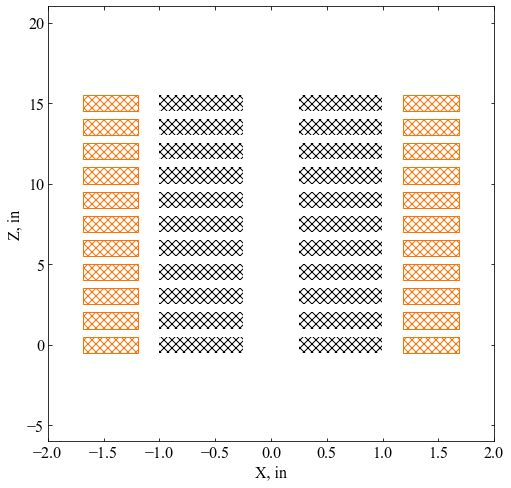

In [53]:
G1.plotSetup()

Computing B-field...
Done!
Plotting B-field...


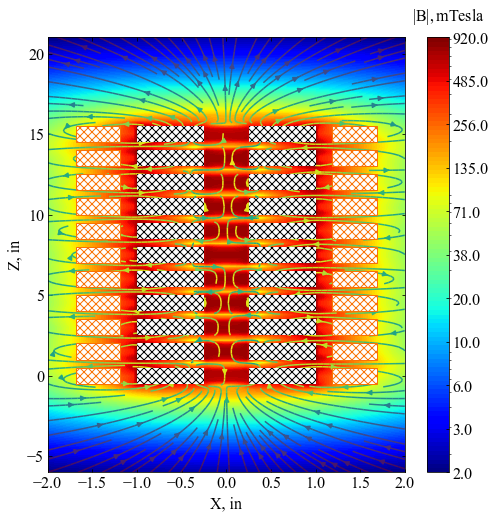

Done!
Computing EMF...
EMF calculated succesfully!


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


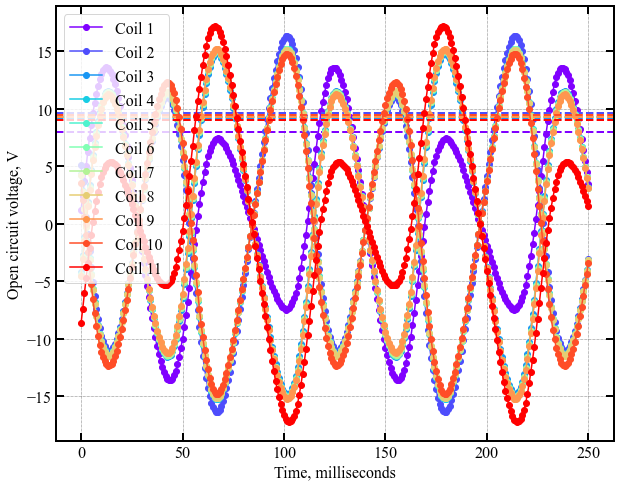

Computing series EMF...
Done.


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


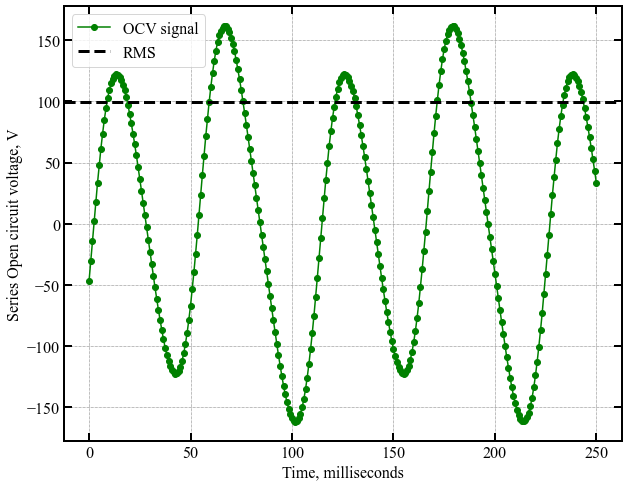

Computing output power and efficiency...
Done.


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


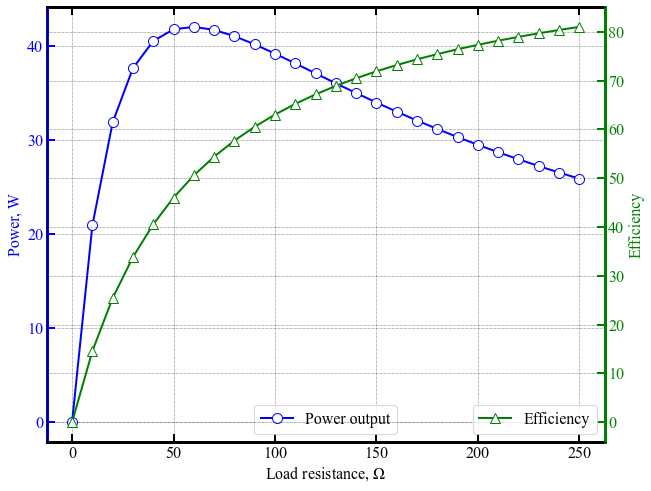

<ipython-input-51-ac3ae7825875>:512: RuntimeWarning: invalid value encountered in double_scalars
  self.efficiency[i] = self.power_arr[i]*100/(self.power_los[i]+self.power_arr[i])


Stroke = 0.0: Total RMS OCV: 0.0 V: Max. power: 0.0 W
Stroke = 0.3: Total RMS OCV: 7.74 V: Max. power: 0.26 W
Stroke = 0.6: Total RMS OCV: 21.55 V: Max. power: 1.98 W
Stroke = 0.9: Total RMS OCV: 42.54 V: Max. power: 7.71 W
Stroke = 1.2: Total RMS OCV: 69.21 V: Max. power: 20.4 W
Stroke = 1.5: Total RMS OCV: 99.28 V: Max. power: 41.99 W
Stroke = 1.8: Total RMS OCV: 130.25 V: Max. power: 72.27 W
Stroke = 2.1: Total RMS OCV: 159.83 V: Max. power: 108.81 W
Stroke = 2.4: Total RMS OCV: 186.32 V: Max. power: 147.88 W
Stroke = 2.7: Total RMS OCV: 208.97 V: Max. power: 186.0 W


No handles with labels found to put in legend.


Stroke = 3.0: Total RMS OCV: 227.98 V: Max. power: 221.39 W


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


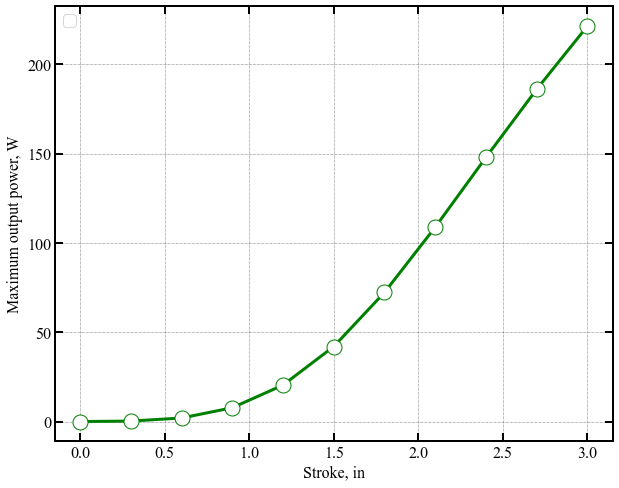

In [54]:
G1.runModel()

In [66]:
G2 = Generator(runID='baseline+20Hz', magnetID_in=0.50, magnetOD_in=2.00, magnetH_in=1.00, 
               magnetPosZ=np.linspace(0, 15, 11, endpoint=True),
               magnetFlipFlag=np.array([1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1]),
               Xmin_in = -2,   Xmax_in=2, num_points_X=100, 
               Zmin_in = -6, Zmax_in=21, num_points_Z=100,
               windingID_in = 2.375, windingOD_in=3.375, windingH_in=1.00, 
               windingPosZ = np.linspace(0,15,11,endpoint=True) - 0.50,
               nSegmentsX = 5, nSegmentsZ=5,
               stroke_in = 1.5, freq=20, runStrokeSweep=True, t_seconds=2*1/20)

Setting up grid...
Done.


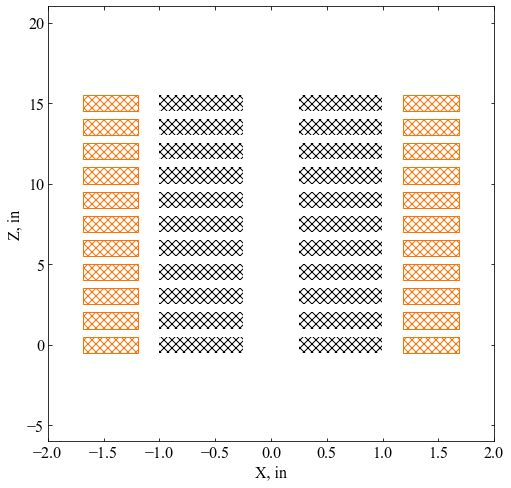

In [67]:
G2.plotSetup()

Computing B-field...
Done!
Plotting B-field...


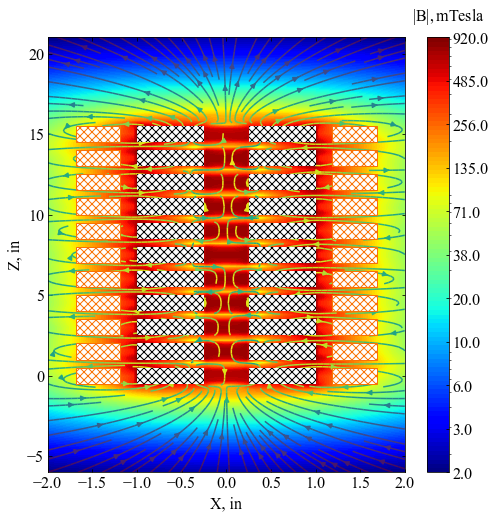

Done!
Computing EMF...
EMF calculated succesfully!


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


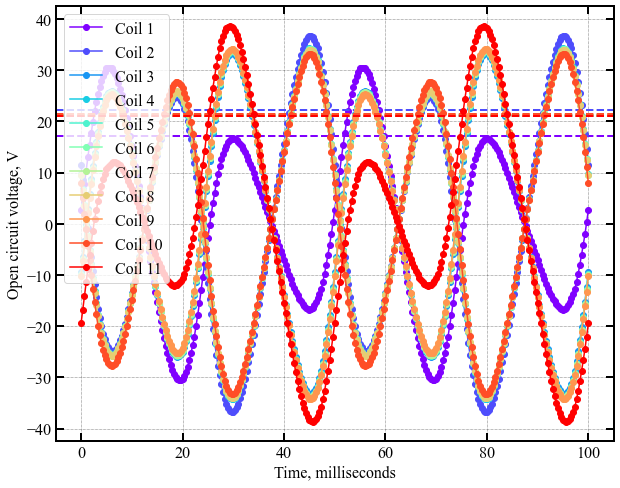

Computing series EMF...
Done.


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


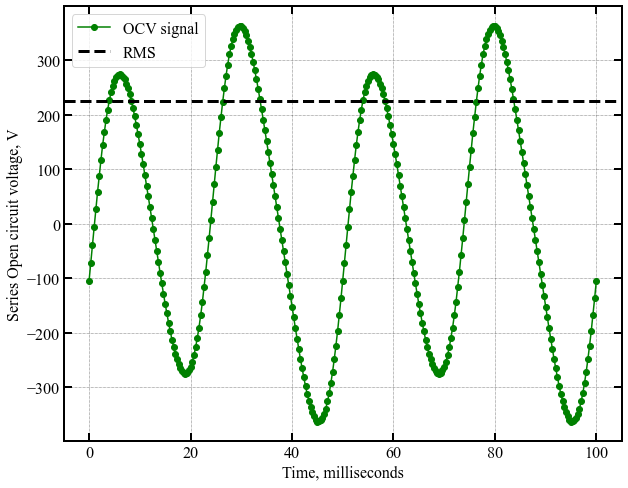

Computing output power and efficiency...
Done.


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


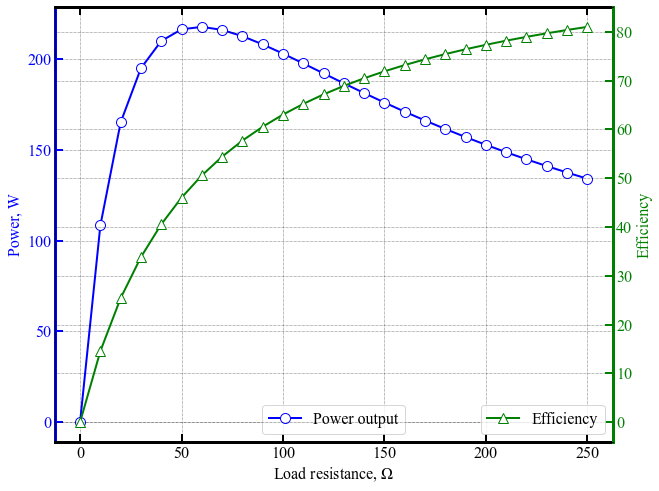

<ipython-input-51-ac3ae7825875>:512: RuntimeWarning: invalid value encountered in double_scalars
  self.efficiency[i] = self.power_arr[i]*100/(self.power_los[i]+self.power_arr[i])


Stroke = 0.0: Total RMS OCV: 0.0 V: Max. power: 0.0 W
Stroke = 0.3: Total RMS OCV: 18.15 V: Max. power: 1.4 W
Stroke = 0.6: Total RMS OCV: 50.35 V: Max. power: 10.8 W
Stroke = 0.9: Total RMS OCV: 98.33 V: Max. power: 41.19 W
Stroke = 1.2: Total RMS OCV: 158.61 V: Max. power: 107.16 W
Stroke = 1.5: Total RMS OCV: 226.05 V: Max. power: 217.66 W
Stroke = 1.8: Total RMS OCV: 295.06 V: Max. power: 370.84 W
Stroke = 2.1: Total RMS OCV: 360.65 V: Max. power: 554.03 W
Stroke = 2.4: Total RMS OCV: 419.16 V: Max. power: 748.38 W
Stroke = 2.7: Total RMS OCV: 469.05 V: Max. power: 937.12 W


No handles with labels found to put in legend.


Stroke = 3.0: Total RMS OCV: 510.95 V: Max. power: 1112.02 W


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


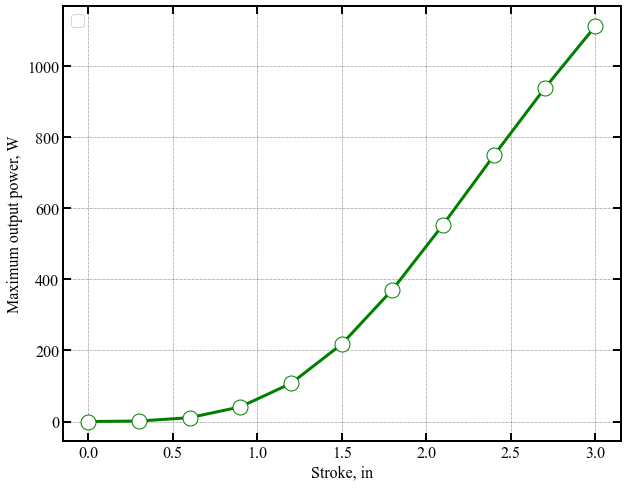

In [68]:
G2.runModel()

In [69]:
G3 = Generator(runID='baseline+20Hz+thin-ring-magnets', magnetID_in=3.5, magnetOD_in=4.00, magnetH_in=1.00, 
               magnetPosZ=np.linspace(0, 15, 11, endpoint=True),
               magnetFlipFlag=np.array([1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1]),
               Xmin_in = -4,   Xmax_in=4, num_points_X=100, 
               Zmin_in = -6, Zmax_in=21, num_points_Z=100,
               windingID_in = 4.05, windingOD_in=5.05, windingH_in=1.00, 
               windingPosZ = np.linspace(0,15,11,endpoint=True) - 0.50,
               nSegmentsX = 5, nSegmentsZ=5,
               stroke_in = 2.0, freq=20.0, runStrokeSweep=True, t_seconds=2*1/20, num_points=301)

Setting up grid...
Done.


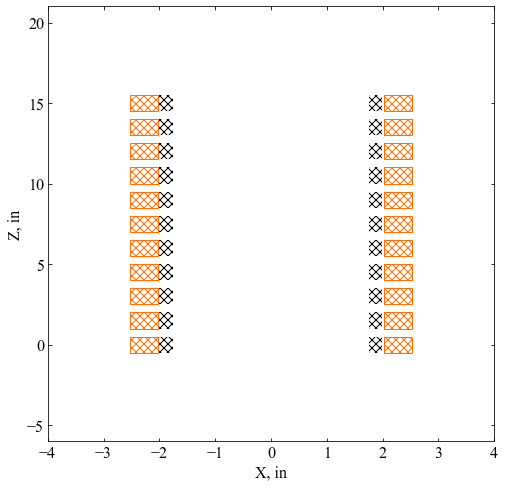

In [70]:
G3.plotSetup()

Computing B-field...
Done!
Plotting B-field...


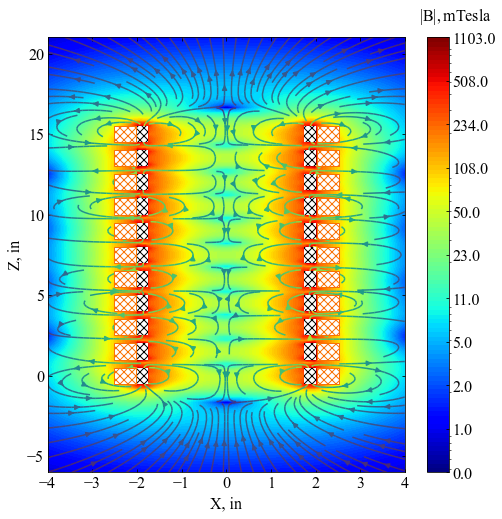

Done!
Computing EMF...
EMF calculated succesfully!


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


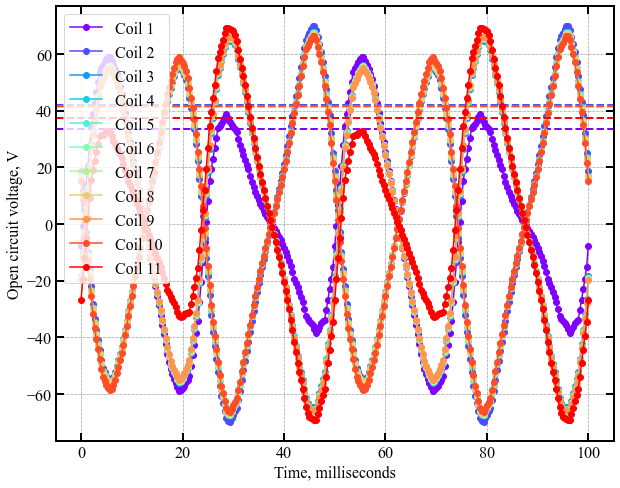

Computing series EMF...
Done.


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


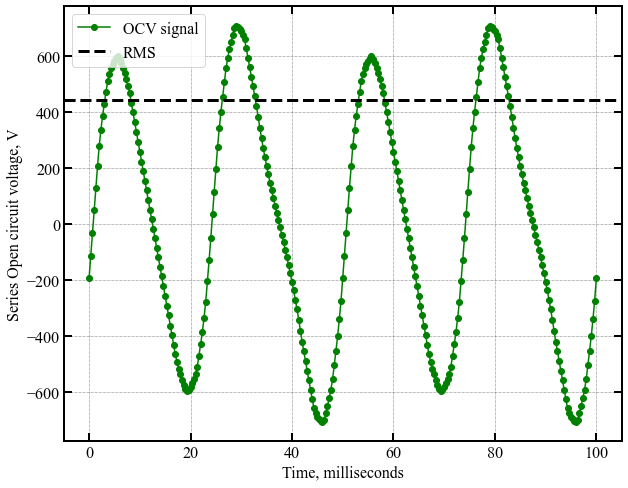

Computing output power and efficiency...
Done.


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


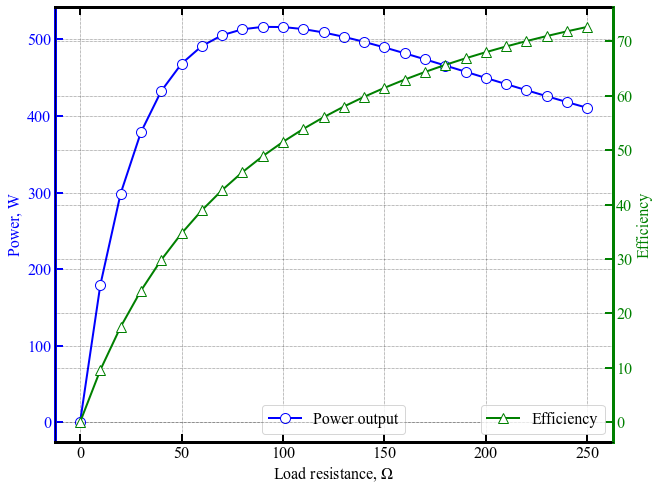

<ipython-input-51-ac3ae7825875>:512: RuntimeWarning: invalid value encountered in double_scalars
  self.efficiency[i] = self.power_arr[i]*100/(self.power_los[i]+self.power_arr[i])


Stroke = 0.0: Total RMS OCV: 0.0 V: Max. power: 0.0 W
Stroke = 0.3: Total RMS OCV: 24.87 V: Max. power: 1.64 W
Stroke = 0.6: Total RMS OCV: 67.01 V: Max. power: 11.92 W
Stroke = 0.9: Total RMS OCV: 128.89 V: Max. power: 44.11 W
Stroke = 1.2: Total RMS OCV: 206.72 V: Max. power: 113.47 W
Stroke = 1.5: Total RMS OCV: 294.28 V: Max. power: 229.95 W
Stroke = 1.8: Total RMS OCV: 383.76 V: Max. power: 391.04 W
Stroke = 2.1: Total RMS OCV: 468.11 V: Max. power: 581.83 W
Stroke = 2.4: Total RMS OCV: 542.91 V: Max. power: 782.62 W
Stroke = 2.7: Total RMS OCV: 606.6 V: Max. power: 977.02 W


No handles with labels found to put in legend.


Stroke = 3.0: Total RMS OCV: 659.84 V: Max. power: 1156.07 W


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


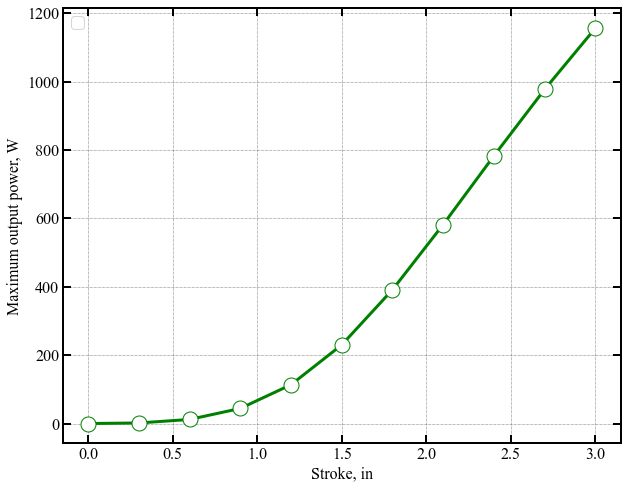

In [71]:
G3.runModel()

In [73]:
G4 = Generator(runID='baseline+30Hz+thin-ring-magnets', magnetID_in=3.5, magnetOD_in=4.00, magnetH_in=1.00, 
               magnetPosZ=np.linspace(0, 15, 11, endpoint=True),
               magnetFlipFlag=np.array([1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1]),
               Xmin_in = -4,   Xmax_in=4, num_points_X=100, 
               Zmin_in = -6, Zmax_in=21, num_points_Z=100,
               windingID_in = 4.05, windingOD_in=5.05, windingH_in=1.00, 
               windingPosZ = np.linspace(0,15,11,endpoint=True) - 0.50,
               nSegmentsX = 5, nSegmentsZ=5,
               stroke_in = 2.0, freq=30.0, runStrokeSweep=True, t_seconds=2*1/30, num_points=301)

Setting up grid...
Done.


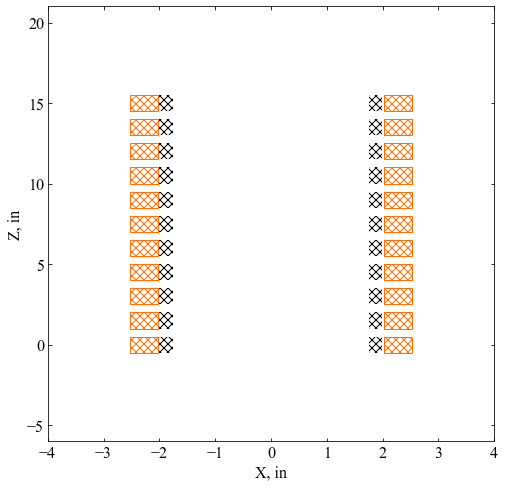

In [74]:
G4.plotSetup()

Computing B-field...
Done!
Plotting B-field...


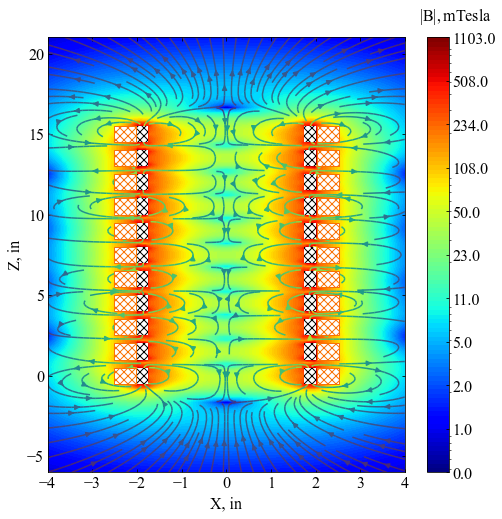

Done!
Computing EMF...
EMF calculated succesfully!


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


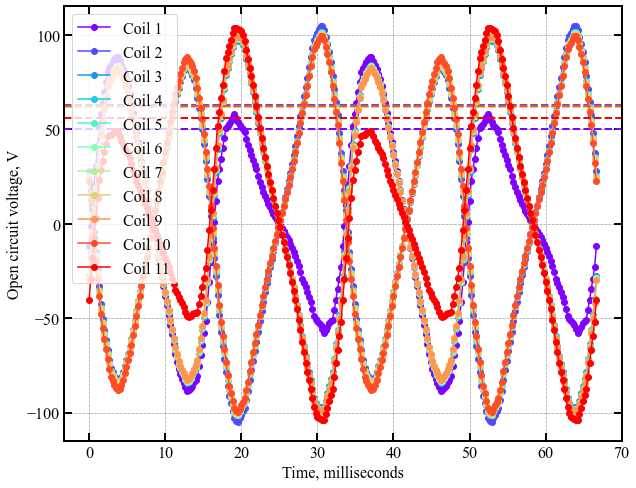

Computing series EMF...
Done.


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


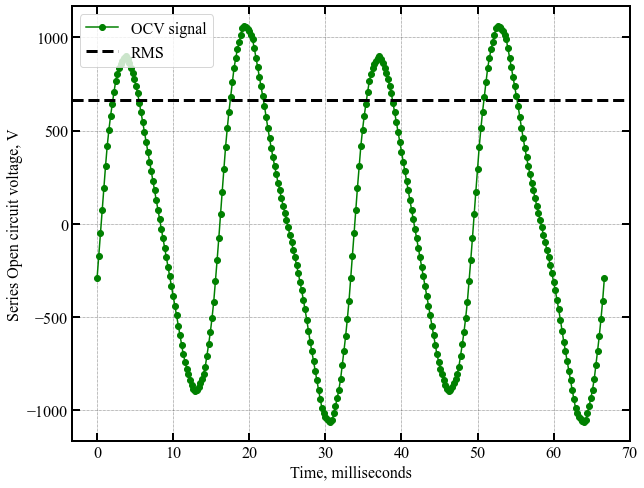

Computing output power and efficiency...
Done.


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


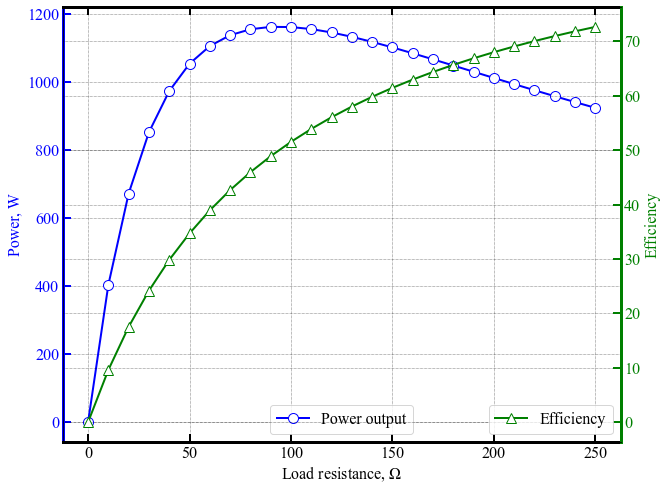

<ipython-input-51-ac3ae7825875>:512: RuntimeWarning: invalid value encountered in double_scalars
  self.efficiency[i] = self.power_arr[i]*100/(self.power_los[i]+self.power_arr[i])


Stroke = 0.0: Total RMS OCV: 0.0 V: Max. power: 0.0 W
Stroke = 0.3: Total RMS OCV: 37.3 V: Max. power: 3.69 W
Stroke = 0.6: Total RMS OCV: 100.52 V: Max. power: 26.83 W
Stroke = 0.9: Total RMS OCV: 193.33 V: Max. power: 99.25 W
Stroke = 1.2: Total RMS OCV: 310.08 V: Max. power: 255.31 W
Stroke = 1.5: Total RMS OCV: 441.42 V: Max. power: 517.38 W
Stroke = 1.8: Total RMS OCV: 575.64 V: Max. power: 879.85 W
Stroke = 2.1: Total RMS OCV: 702.17 V: Max. power: 1309.12 W
Stroke = 2.4: Total RMS OCV: 814.36 V: Max. power: 1760.91 W
Stroke = 2.7: Total RMS OCV: 909.9 V: Max. power: 2198.3 W


No handles with labels found to put in legend.


Stroke = 3.0: Total RMS OCV: 989.77 V: Max. power: 2601.15 W


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


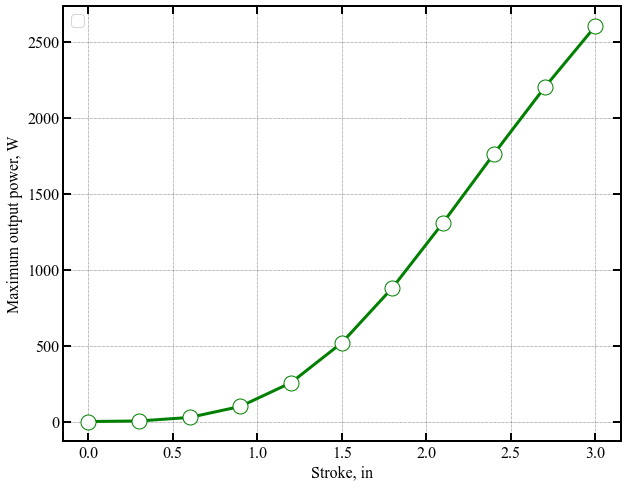

In [75]:
G4.runModel()

In [29]:
G2 = Generator(runID='single-coil', magnetID_in=0.50, magnetOD_in=2.00, magnetH_in=1.00, 
               magnetPosZ=np.linspace(0, 1.5, 2, endpoint=True),
               magnetFlipFlag=np.array([1, -1]),
               Xmin_in = -2,   Xmax_in=2, num_points_X=100, 
               Zmin_in = -2, Zmax_in=3, num_points_Z=100,
               windingID_in = 2.375, windingOD_in=3.375, windingH_in=1.00, 
               windingPosZ = np.linspace(0,1.5,1,endpoint=True)+0.25,
               nSegmentsX = 5, nSegmentsZ=5,
               stroke_in = 1.5, freq=8.90, runStrokeSweep=False)

Setting up grid...
Done.


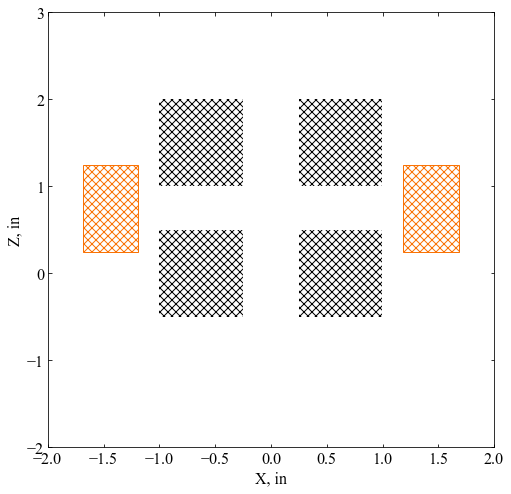

In [30]:
G2.plotSetup()

Computing B-field...
Done!
Plotting B-field...


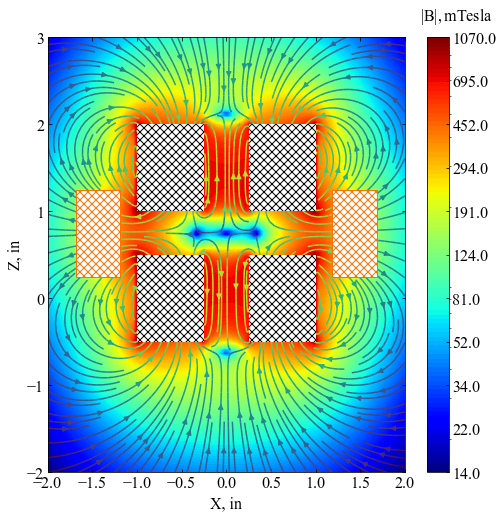

Done!
Computing EMF...
EMF calculated succesfully!


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


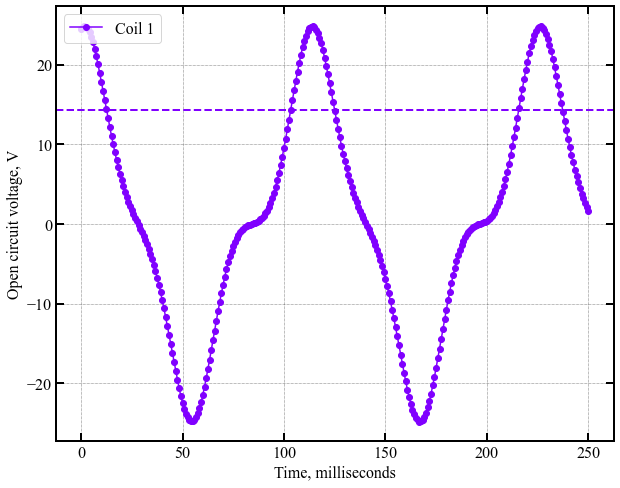

Computing series EMF...
Done.


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


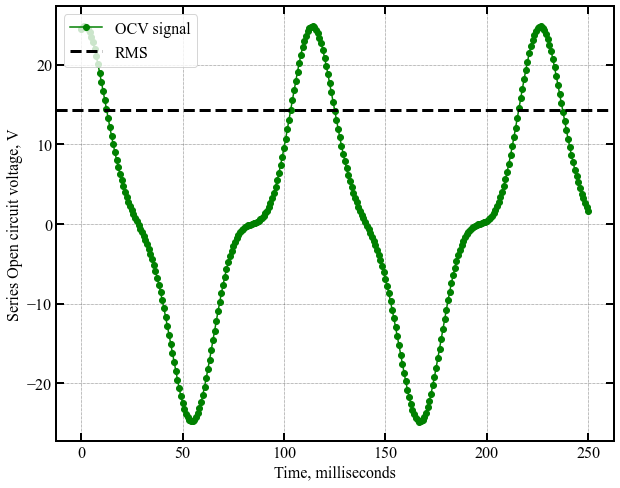

Computing output power and efficiency...
Done.


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


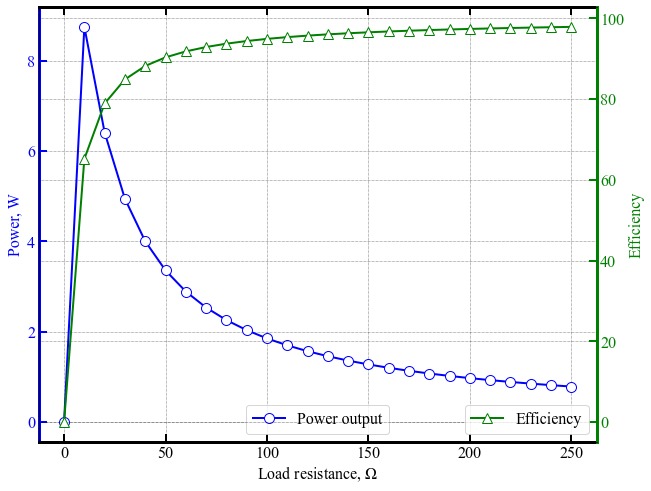

In [31]:
G2.runModel()